In [1]:
from __future__ import annotations
from typing import Union, Dict, Any

from shapely.geometry import shape, Polygon, MultiPolygon
import geopandas as gpd
import pandas as pd
from OSMPythonTools.overpass import Overpass

def _geojson_to_polygon(aoi: Union[Dict[str, Any], Polygon, MultiPolygon]) -> Polygon | MultiPolygon:
    """Accept a GeoJSON dict *or* Shapely geometry and return a Shapely polygon/multipolygon."""
    if isinstance(aoi, (Polygon, MultiPolygon)):
        return aoi
    if isinstance(aoi, dict):
        return shape(aoi)
    raise TypeError("AOI must be a GeoJSON-like dict or a shapely Polygon/MultiPolygon")

def _poly_to_overpass_string(poly: Polygon | MultiPolygon) -> str:
    """Convert exterior ring(s) to the 'lat lon lat lon …' format Overpass expects."""
    if isinstance(poly, Polygon):
        rings = [poly.exterior.coords]
    else:  # MultiPolygon
        rings = [p.exterior.coords for p in poly.geoms]

    parts = []
    for ring in rings:
        parts.extend(f"{lat} {lon}" for lon, lat in ring)
    return " ".join(parts)

def _build_query(coords_str: str) -> str:
    """Raw Overpass QL requesting full geometry for land-use / natural / land-cover."""
    return f"""
    (
      way["landuse"](poly:"{coords_str}");
      way["natural"](poly:"{coords_str}");
      way["landcover"](poly:"{coords_str}");
      relation["landuse"](poly:"{coords_str}");
      relation["natural"](poly:"{coords_str}");
      relation["landcover"](poly:"{coords_str}");
    );
    out geom;
    """

def _elements_to_gdf(result) -> gpd.GeoDataFrame:
    """Convert OSMPythonTools elements → GeoPandas GeoDataFrame (EPSG:4326)."""
    geometries, attrs = [], []
    for el in result.elements():
        tags = el.tags()
        if not tags:
            continue
        geom = shape(el.geometry())
        if not geom.geom_type.startswith("Polygon"):
            continue
        geometries.append(geom)
        attrs.append(tags)

    gdf = gpd.GeoDataFrame(attrs, geometry=geometries, crs="EPSG:4326")
    # gdf["cover"] = (
    #     gdf.get("landuse")
    #        .fillna(gdf.get("natural"))
    #        # .fillna(gdf.get("landcover"))
    # )
    cols = [c for c in ("landuse", "natural", "landcover") if c in gdf.columns]
    if cols:                                      # at least one tag present
        gdf["cover"] = gdf[cols].bfill(axis=1).iloc[:, 0]
    else:                                         # none of the tags exist
        gdf["cover"] = pd.Series(pd.NA, index=gdf.index, dtype="object")

    return gdf

# ---------------------------------------------------------------------------

def get_osm_landcover(
    aoi_geojson: Union[Dict[str, Any], Polygon, MultiPolygon],
    out_crs: str | int = "EPSG:3857",
) -> gpd.GeoDataFrame:
    """
    Retrieve OSM land-use / natural / land-cover polygons intersecting *aoi_geojson*.

    Parameters
    ----------
    aoi_geojson : dict | shapely Polygon/MultiPolygon
        The area of interest.  If dict, must be GeoJSON-like.
    out_crs : str | int, default "EPSG:3857"
        The CRS you want the result in (e.g. 4326, 3857, or any proj string).

    Returns
    -------
    GeoDataFrame
        Columns: all original OSM tag columns + 'cover' (categorical label).
        CRS: *out_crs*.
    """
    # 1. normalise AOI input
    poly = _geojson_to_polygon(aoi_geojson)

    # 2. build & run Overpass query
    overpass = Overpass()
    query = _build_query(_poly_to_overpass_string(poly))
    result = overpass.query(query)

    # 3. convert to GeoDataFrame
    gdf = _elements_to_gdf(result)

    # 4. clip to AOI
    aoi_gs = gpd.GeoSeries([poly], crs="EPSG:4326")
    gdf = gpd.clip(gdf, aoi_gs)

    # 5. project to requested CRS
    if out_crs:
        gdf = gdf.to_crs(out_crs)

    return gdf


In [2]:
# # ── Cell 1 ──  Define a sample AOI (≈ 8 km-wide hexagon in the Santa Monica Mtns)
# sample_geojson = {
#     "type": "Polygon",
#     "coordinates": [[
#         [-118.526522, 34.050000],      # E
#         [-118.548261, 34.081195],      # NE
#         [-118.591739, 34.081195],      # NW
#         [-118.613478, 34.050000],      # W
#         [-118.591739, 34.018805],      # SW
#         [-118.548261, 34.018805],      # SE
#         [-118.526522, 34.050000]       # close ring
#     ]]
# }


# # ≈5-mile-wide hexagon centred on Icehouse Canyon (34.250 N, -117.635 W)
# sample_geojson = {
#     "type": "Polygon",
#     "coordinates": [[
#         [-117.5915, 34.2500],  # E
#         [-117.6133, 34.2860],  # NE
#         [-117.6568, 34.2860],  # NW
#         [-117.6785, 34.2500],  # W
#         [-117.6568, 34.2140],  # SW
#         [-117.6133, 34.2140],  # SE
#         [-117.5915, 34.2500]   # close ring
#     ]]
# }

# ≈5 mi / 8 km-wide hexagon centred on Sheep Mountain Wilderness
sample_geojson = {
    "type": "Polygon",
    "coordinates": [[
        [-117.6065, 34.2900],  # East
        [-117.6283, 34.3260],  # North-east
        [-117.6717, 34.3260],  # North-west
        [-117.6935, 34.2900],  # West
        [-117.6717, 34.2540],  # South-west
        [-117.6283, 34.2540],  # South-east
        [-117.6065, 34.2900]   # close ring
    ]]
}


In [3]:
# ── Cell 2 ──  Fetch OSM land-cover / land-use polygons clipped to the AOI
# from landcover_osm import get_osm_landcover
import geopandas as gpd

gdf = get_osm_landcover(sample_geojson, out_crs=3857)  # Web-Mercator for plotting
print(f"{len(gdf):,} polygons returned")
display(gdf.head())


28 polygons returned


,natural,landuse,name,sport,leaf_cycle,leaf_type,wood:density,type,geometry,cover
8,shingle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13099617.593 4063957.381, -13099636...",shingle
2,scrub,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13099157.621 4063510.887, -13099073...",scrub
18,wood,NaN,NaN,NaN,evergreen,needleleaved,NaN,NaN,"POLYGON ((-13095507.232 4063039.226, -13095372...",wood
22,scree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13095183.96 4064191.207, -13095220....",scree
23,shingle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13095168.153 4064208.314, -13095117...",shingle


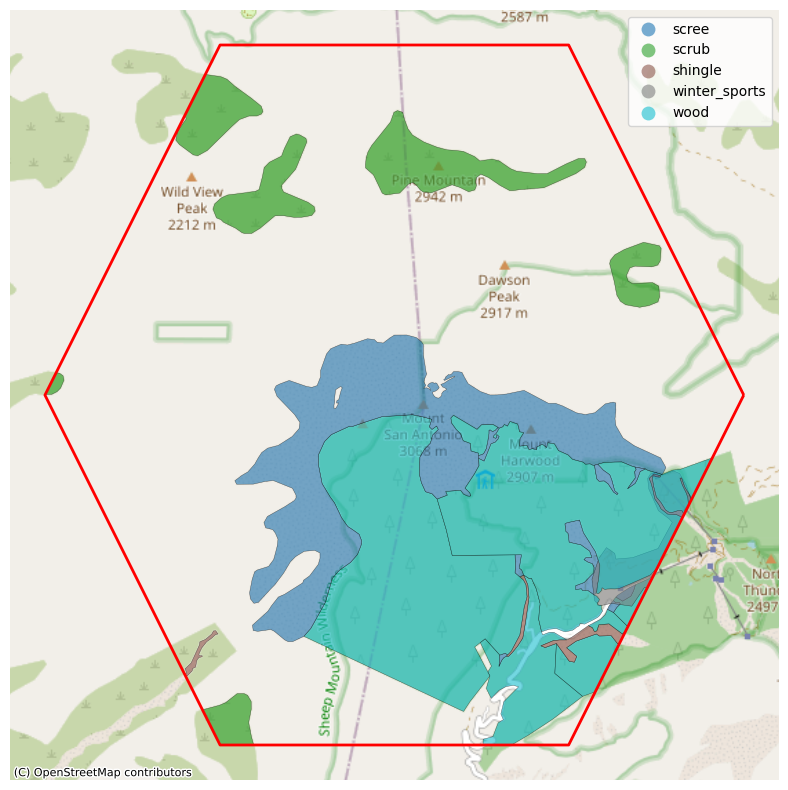

In [4]:
# ── Cell 3 ──  Plot polygons colour-coded by “cover” + AOI outline
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import shape

fig, ax = plt.subplots(figsize=(8, 8))

# land-cover
gdf.plot(
    ax=ax,
    column="cover",
    categorical=True,
    legend=True,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.3,
)

# AOI boundary in red
aoi_web = (
    gpd.GeoSeries([shape(sample_geojson)], crs="EPSG:4326")
    .to_crs(3857)
)
aoi_web.boundary.plot(ax=ax, linewidth=2, color="red")

# Basemap & cosmetics
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [5]:
# postprocess_cover.py  ────────────────────────────────────────────────────
from __future__ import annotations

from typing import List, Union

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio import features
from scipy import ndimage as ndi
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union

# -------------------------------------------------------------------------
def remove_overlaps(
    gdf: gpd.GeoDataFrame,
    cover_col: str = "cover",
) -> gpd.GeoDataFrame:
    """
    Resolve overlapping polygons by **keeping the larger area** feature.

    Any overlap is subtracted from smaller polygons so the result layer has
    no geometry intersections at all.

    Returns
    -------
    GeoDataFrame without overlaps.
    """
    # sort by area descending
    gdf_tmp = gdf.assign(_area=gdf.area).sort_values("_area", ascending=False)
    kept_rows: List[dict] = []
    union_kept = None

    for _, row in gdf_tmp.iterrows():
        geom = row.geometry
        if union_kept:
            geom = geom.difference(union_kept)
        if geom.is_empty:
            continue

        new_row = row.drop(labels=["_area"]).to_dict()
        new_row["geometry"] = geom
        kept_rows.append(new_row)

        union_kept = union_kept.union(geom) if union_kept else geom

    return gpd.GeoDataFrame(kept_rows, crs=gdf.crs).reset_index(drop=True)


# -------------------------------------------------------------------------
def smooth_cover_layer(
    gdf: gpd.GeoDataFrame,
    cover_col: str = "cover",
    tol: float = 10.0,
    min_area: float | None = None,
) -> gpd.GeoDataFrame:
    """
    Morphological smoothing: erode by *tol* then dilate by *tol*.
    Removes corridors/spikes narrower than 2×tol.  Parts < *min_area* drop.
    """
    if min_area is None:
        min_area = tol ** 2

    new_geom, new_cov = [], []

    for cov, geom in zip(gdf[cover_col], gdf.geometry):
        try:
            g = geom.buffer(-tol).buffer(tol)
        except ValueError:
            continue
        if g.is_empty:
            continue

        parts = g.geoms if g.geom_type == "MultiPolygon" else [g]
        for p in parts:
            if p.area >= min_area:
                new_geom.append(p)
                new_cov.append(cov)

    if not new_geom:
        return gdf.copy()

    smoothed = gpd.GeoDataFrame(
        {cover_col: new_cov, "geometry": new_geom}, crs=gdf.crs
    )
    return (
        smoothed
        .dissolve(by=cover_col, as_index=False)
        .explode(index_parts=False)
        .reset_index(drop=True)
    )


# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
#  REPLACE OLD expand_to_fill_aoi WITH THIS ITERATIVE VERSION
# -------------------------------------------------------------------------
def expand_to_fill_aoi(
    gdf: gpd.GeoDataFrame,
    aoi: Union[Polygon, MultiPolygon, gpd.GeoSeries],
    cover_col: str = "cover",
    pixel_size: float = 5.0,        # metres per pixel in output grid
) -> gpd.GeoDataFrame:
    """
    Fill every remaining gap by assigning each map pixel to the **closest
    polygon boundary** (Euclidean distance).

    Parameters
    ----------
    pixel_size : float
        Output raster resolution.  Use ~ map-scale pixel size; e.g. 5 m
        makes final slivers < 5 m vanish.

    Returns
    -------
    GeoDataFrame  – polygons after simultaneous expansion.
    """
    # 0.  Geometry prep ---------------------------------------------------
    if isinstance(aoi, gpd.GeoSeries):
        aoi_poly = aoi.iloc[0]
    else:
        aoi_poly = aoi

    # Ensure the layer has an integer ID for raster labels
    gdf = gdf.reset_index(drop=True).copy()
    gdf["_id"] = np.arange(1, len(gdf) + 1, dtype=np.int32)

    # 1.  Build an “analysis raster” covering the AOI ---------------------
    minx, miny, maxx, maxy = aoi_poly.bounds
    width  = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))

    transform = rasterio.transform.from_origin(minx, maxy, pixel_size, pixel_size)
    out_shape = (height, width)

    # 1a. Rasterise ONLY the polygon interiors (id value), 0 = nodata
    interior = features.rasterize(
        ((geom, fid) for geom, fid in zip(gdf.geometry, gdf["_id"])),
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype="int32",
        all_touched=False,          # only interior pixels
    )

    # 1b. Mask exterior-of-AOI pixels so we never assign outside area
    aoi_mask = features.geometry_mask(
        [aoi_poly], out_shape=out_shape, transform=transform, invert=True
    )
    interior = np.where(aoi_mask, interior, -1)     # -1 = outside study area

    # 2.  Distance transform on the “gaps” (pixels == 0) ------------------
    gap_mask = interior == 0
    if not gap_mask.any():
        # already full – just vectorise & quit
        return gdf.drop(columns="_id")

    # Compute distance to nearest labelled pixel & the argmin label
    # Step 1: distance to *all* non-gap pixels
    dist, indices = ndi.distance_transform_edt(
        gap_mask,
        return_indices=True,
    )

    # Map row/col of nearest source pixel back to its label
    nearest_labels = interior[indices[0], indices[1]]
    # Write these labels into the gap pixels
    filled = interior.copy()
    filled[gap_mask] = nearest_labels[gap_mask]

    # 3.  Vectorise back to polygons --------------------------------------
    shapes = features.shapes(filled.astype("int32"), mask=(filled > 0), transform=transform)
    records = []
    for geom, value in shapes:
        poly = shape(geom)
        fid  = int(value)
        if poly.is_empty:
            continue
        records.append({"_id": fid, "geometry": poly})

    expanded = gpd.GeoDataFrame(records, crs=gdf.crs)

    # 4.  Join cover attribute back, dissolve on cover --------------------
    expanded = expanded.merge(
        gdf[["_id", cover_col]], on="_id", how="left", validate="m:1"
    ).drop(columns="_id")

    expanded = (
        expanded.dissolve(by=cover_col, as_index=False)
                .explode(index_parts=False)
                .reset_index(drop=True)
    )
    return expanded

# -------------------------------------------------------------------------
#  FINAL GAP FILL – push polygons out to the AOI boundary
# -------------------------------------------------------------------------
def fill_to_aoi_boundary(
    gdf: gpd.GeoDataFrame,
    aoi: Union[Polygon, MultiPolygon, gpd.GeoSeries],
    cover_col: str = "cover",
    max_iter: int = 3,            # usually one pass is enough
) -> gpd.GeoDataFrame:
    """
    Close any residual gaps (typically slender strips along the AOI edge)
    by assigning each gap the *cover* of its neighbouring polygon that has
    the longest shared boundary with it.

    The process repeats up to *max_iter* times; it almost always converges
    after the first pass once the big raster-based expansion has run.
    """
    if isinstance(aoi, gpd.GeoSeries):
        aoi_poly = aoi.iloc[0]
    else:
        aoi_poly = aoi

    work = gdf.copy()

    for _ in range(max_iter):
        gap_poly = aoi_poly.difference(unary_union(work.geometry))
        if gap_poly.is_empty:
            break

        gaps = list(gap_poly.geoms) if gap_poly.geom_type == "MultiPolygon" else [gap_poly]
        additions = []

        for gap in gaps:
            # neighbours that touch this gap
            nbrs = work[work.touches(gap)]
            if nbrs.empty:
                # this can happen if the gap only touches AOI edge
                continue

            shared_len = nbrs.geometry.boundary.intersection(gap.boundary).length
            best_idx   = shared_len.idxmax()
            best_cover = nbrs.loc[best_idx, cover_col]

            additions.append({cover_col: best_cover, "geometry": gap})

        if not additions:
            break

        work = pd.concat(
            [work, gpd.GeoDataFrame(additions, crs=work.crs)],
            ignore_index=True,
        )
        # dissolve so the next round sees merged polygons
        work = (
            work.dissolve(by=cover_col, as_index=False)
                .explode(index_parts=False)
                .reset_index(drop=True)
        )

    return work

# -------------------------------------------------------------------------
def dissolve_cover(
    gdf: gpd.GeoDataFrame,
    cover_col: str = "cover",
) -> gpd.GeoDataFrame:
    """Merge adjacent polygons that share the same cover value."""
    return (
        gdf.dissolve(by=cover_col, as_index=False)
           .explode(index_parts=False)
           .reset_index(drop=True)
    )


# -------------------------------------------------------------------------
def refine_cover_layer(
    gdf, aoi,
    cover_col="cover",
    smooth_tol=10.0,
    pixel_size=5.0,
):
    work = remove_overlaps(gdf, cover_col=cover_col)
    work = dissolve_cover(work, cover_col=cover_col)
    work = smooth_cover_layer(work, cover_col=cover_col, tol=smooth_tol)
    work = expand_to_fill_aoi(work, aoi,
                              cover_col=cover_col,
                              pixel_size=pixel_size)
    work = fill_to_aoi_boundary(work, aoi, cover_col=cover_col)
    # tidy
    work = dissolve_cover(work, cover_col=cover_col)
    return work.reset_index(drop=True)


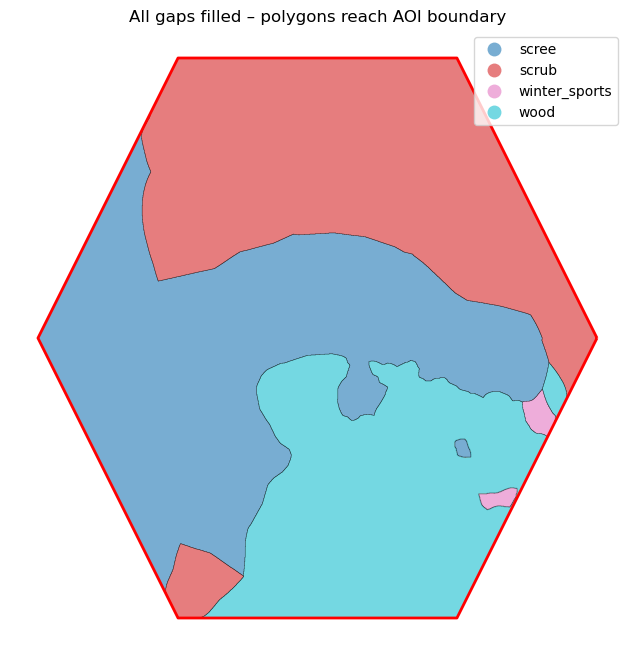

In [6]:
# ------------------------------------------------------------------
# 1.  Fetch raw OSM polygons (previous steps)
gdf_raw = get_osm_landcover(sample_geojson, out_crs=3857)

# 2.  Post-process
# from postprocess_cover import clean_cover_layer

aoi_web = (
    gpd.GeoSeries([shape(sample_geojson)], crs="EPSG:4326")
        .to_crs(3857)
)



gdf_final = refine_cover_layer(gdf_raw, aoi_web,
                               smooth_tol=100,
                               pixel_size=5)

ax = gdf_final.plot(column="cover", figsize=(8, 8), alpha=0.6,
                    edgecolor="k", linewidth=0.3, legend=True)
aoi_web.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title("All gaps filled – polygons reach AOI boundary")
ax.set_axis_off()


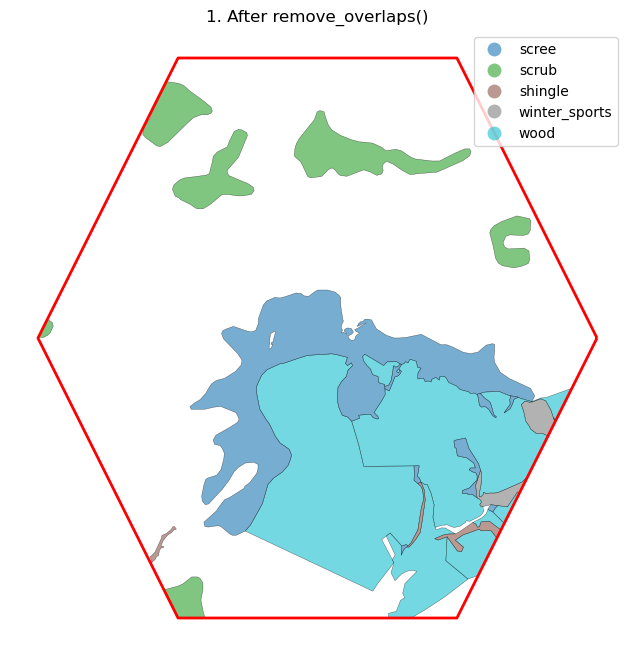

In [7]:
gdf_no_overlaps = remove_overlaps(gdf_raw, cover_col="cover")

ax = gdf_no_overlaps.plot(column="cover", figsize=(8, 8), alpha=0.6,
                          edgecolor="k", linewidth=0.3, legend=True)
aoi_web.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title("1. After remove_overlaps()")
ax.set_axis_off()


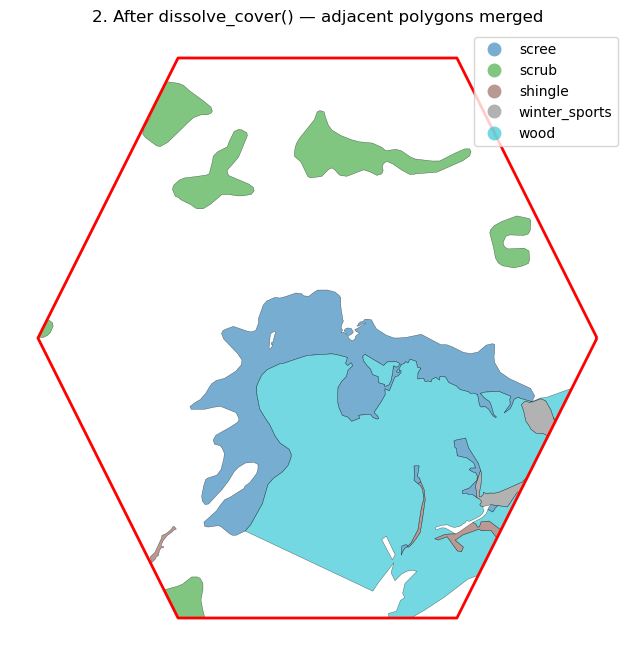

In [8]:
gdf_merged = dissolve_cover(gdf_no_overlaps, cover_col="cover")

ax = gdf_merged.plot(column="cover", figsize=(8, 8), alpha=0.6,
                     edgecolor="k", linewidth=0.3, legend=True)
aoi_web.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title("2. After dissolve_cover() — adjacent polygons merged")
ax.set_axis_off()

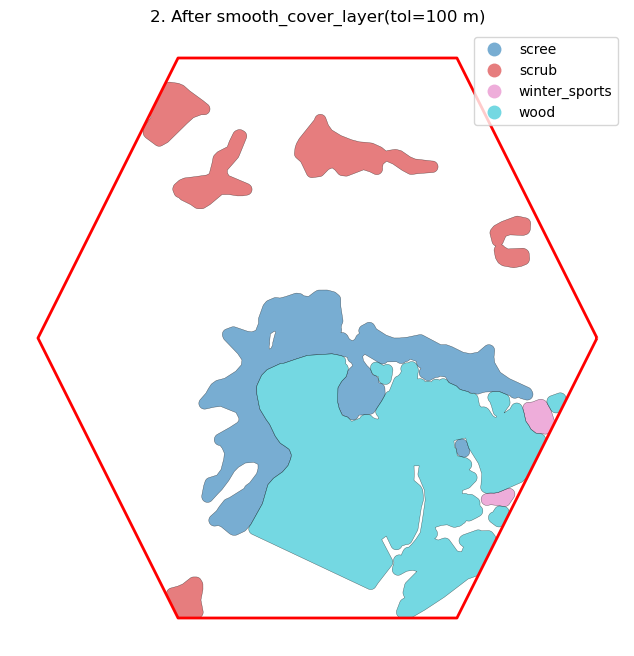

In [9]:

smooth_tol = 100      # ← try bumping this up if skinny slivers remain
gdf_smooth = smooth_cover_layer(gdf_merged,
                                cover_col="cover",
                                tol=smooth_tol)

ax = gdf_smooth.plot(column="cover", figsize=(8, 8), alpha=0.6,
                     edgecolor="k", linewidth=0.3, legend=True)
aoi_web.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title(f"2. After smooth_cover_layer(tol={smooth_tol} m)")
ax.set_axis_off()


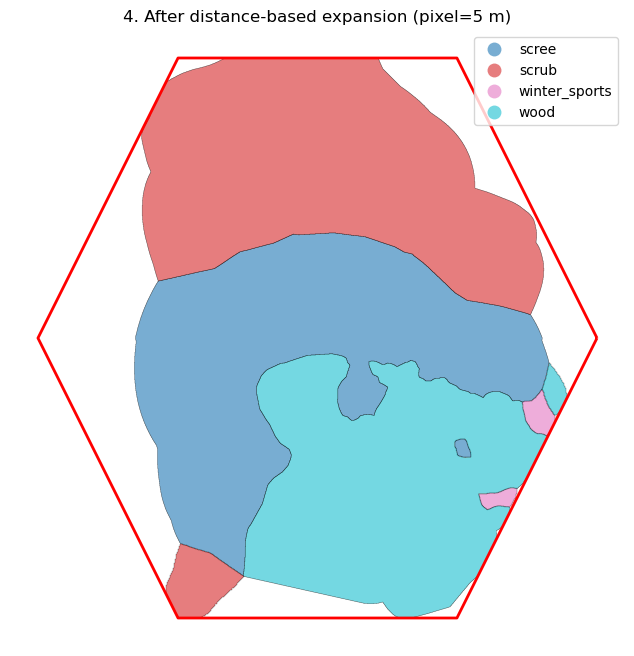

In [10]:
pixel_size = 5      # metres; set to your map pixel size
gdf_expanded = expand_to_fill_aoi(gdf_smooth, aoi_web,
                                  cover_col="cover",
                                  pixel_size=pixel_size)

ax = gdf_expanded.plot(column="cover", figsize=(8, 8), alpha=0.6,
                       edgecolor="k", linewidth=0.3, legend=True)
aoi_web.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title(f"4. After distance-based expansion (pixel={pixel_size} m)")
ax.set_axis_off()

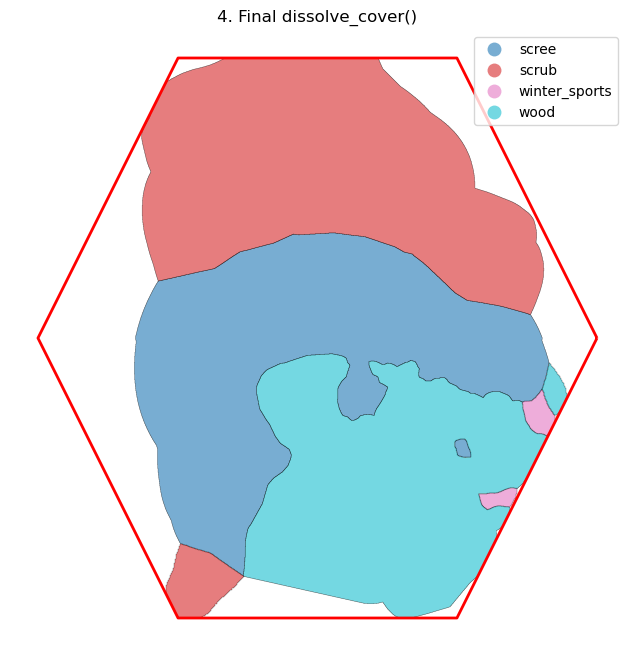

In [11]:

gdf_final = dissolve_cover(gdf_expanded, cover_col="cover")

ax = gdf_final.plot(column="cover", figsize=(8, 8), alpha=0.6,
                    edgecolor="k", linewidth=0.3, legend=True)
aoi_web.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title("4. Final dissolve_cover()")
ax.set_axis_off()
